Object Detection & Recognition


Installing libraries


In [3]:
import numpy as np
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import json
import torch
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as transforms
import cv2
import os
import csv

some metadata for the annotations by opening the file annotations/instances_val2017.json as below

In [6]:
instances = dict(json.loads(open('instances_val2017.json').read()))
print('Types of annotation:', ', '.join(list(instances.keys())))

Types of annotation: info, licenses, images, annotations, categories


Dataset annotations


In [7]:
categories = [cat['name'] for cat in instances['categories']]
print('Number of categories:',len(categories))
print('Example categories:', ', '.join(categories[:10]))

Number of categories: 80
Example categories: person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light


COCO API


In [8]:
coco = COCO('instances_val2017.json')


loading annotations into memory...
Done (t=0.67s)
creating index...
index created!


Visualize images with bounding boxes from the COCO dataset


In [9]:
example_categories = ['person','dog','skateboard']
example_cat_ids = coco.getCatIds(example_categories)
img_ids = coco.getImgIds(catIds=example_cat_ids)
imgs = coco.loadImgs(img_ids)

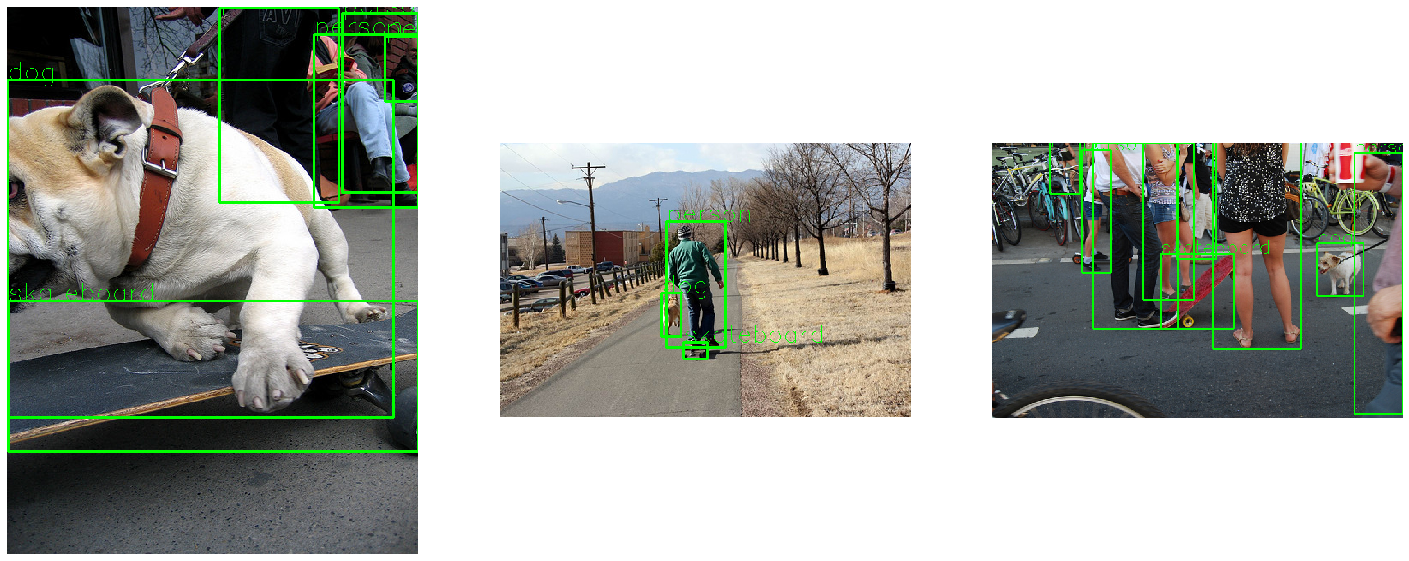

In [10]:
boxed_imgs = []
for img in imgs:
  I = io.imread(img['coco_url'])
  img_id = img['id']
  anns = coco.loadAnns(coco.getAnnIds(img_id, example_cat_ids))
  cat_ids = [ann['category_id'] for ann in anns]
  labels = [example_categories[example_cat_ids.index(id)] for id in cat_ids]
  boxes = [ann['bbox'] for ann in anns]
  new_boxes = []
  for box in boxes:
    coord = [box[0], box[1], box[0]+box[2], box[1]+box[3]] #Convert co-ordinates from COCO format to that accepted by OpenCV
    coord = [int(item) for item in coord]
    new_boxes.append([(coord[0], coord[1]), (coord[2], coord[3])])

  for i,box in enumerate(new_boxes):
    cv2.rectangle(I, box[0], box[1], color=(0, 255, 0), thickness=2)
    cv2.putText(I, labels[i], box[0],  cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),thickness=1)

  boxed_imgs.append(I)

fig = plt.figure(figsize=(25,15))
for i,I in enumerate(boxed_imgs):
  plt.subplot(1,len(imgs),i+1)
  plt.axis('off')
  plt.imshow(I)

Faster R-CNN model


In [11]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval();

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\dhiva/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [12]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Inference Pipeline


In [13]:
def get_prediction(img_url, threshold):
  img = io.imread(img_url) # Load image
  transform = transforms.Compose([transforms.ToTensor()])
  img = transform(img) # Transform image into format accepted by the model class
  pred = model([img]) # Perform inference on the image
  pred_labels = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] 
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold] # Filter for boxes that have confidence score above threshold
  if not pred_t:
    return pred_boxes, pred_labels

  else:
    pred_t = pred_t[-1]

  pred_boxes = pred_boxes[:pred_t+1]
  pred_labels = pred_labels[:pred_t+1]
  return pred_boxes, pred_labels

In [14]:
def get_objects(img_url, threshold=0.5, categories=None):

  boxes, pred_labels = get_prediction(img_url, threshold) # Perform inference
  if categories: # Filter for categories of interest
    boxes = [boxes[i] for i in range(len(boxes)) if pred_labels[i] in categories]
    pred_labels = [item for item in pred_labels if item in categories]

  img = io.imread(img_url)
  for i,box in enumerate(boxes): # Draw rectangles
    cv2.rectangle(img, box[0], box[1],color=(0, 255, 0), thickness=2)
    cv2.putText(img, pred_labels[i], box[0], cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),thickness=1) 
  
  return img, boxes, pred_labels

Visualising images


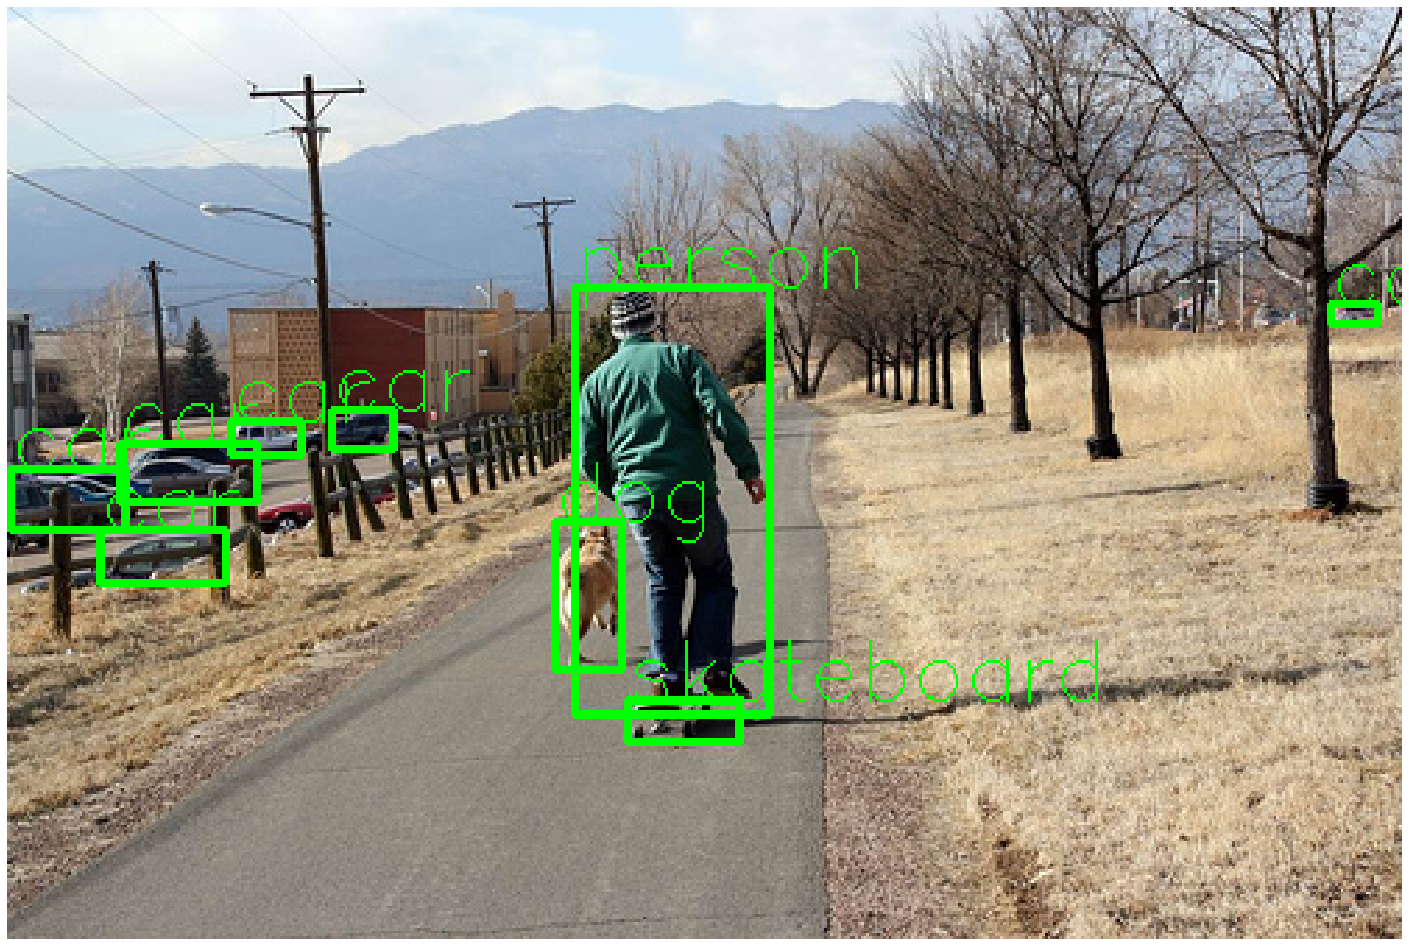

In [27]:
img_url = 'http://images.cocodataset.org/val2017/000000324158.jpg'
boxed_img,_,_ = get_objects(img_url, threshold=0.8)
plt.figure(figsize=(25,20))
plt.axis('off')
plt.imshow(boxed_img)
plt.show()

Pedestrian Detection

In [19]:
img_dir = 'C:/Users/dhiva/Desktop/eckovation dhivakar/16/PennFudanPed/PNGImages'
img_filenames = os.listdir(img_dir)
img_paths = [os.path.join(img_dir, filename) for filename in img_filenames]

In [20]:
img_path = np.random.choice(img_paths)
boxed_img, boxes, _ = get_objects(img_path, threshold=0.8, categories=['person'])
num_ped = len(boxes)

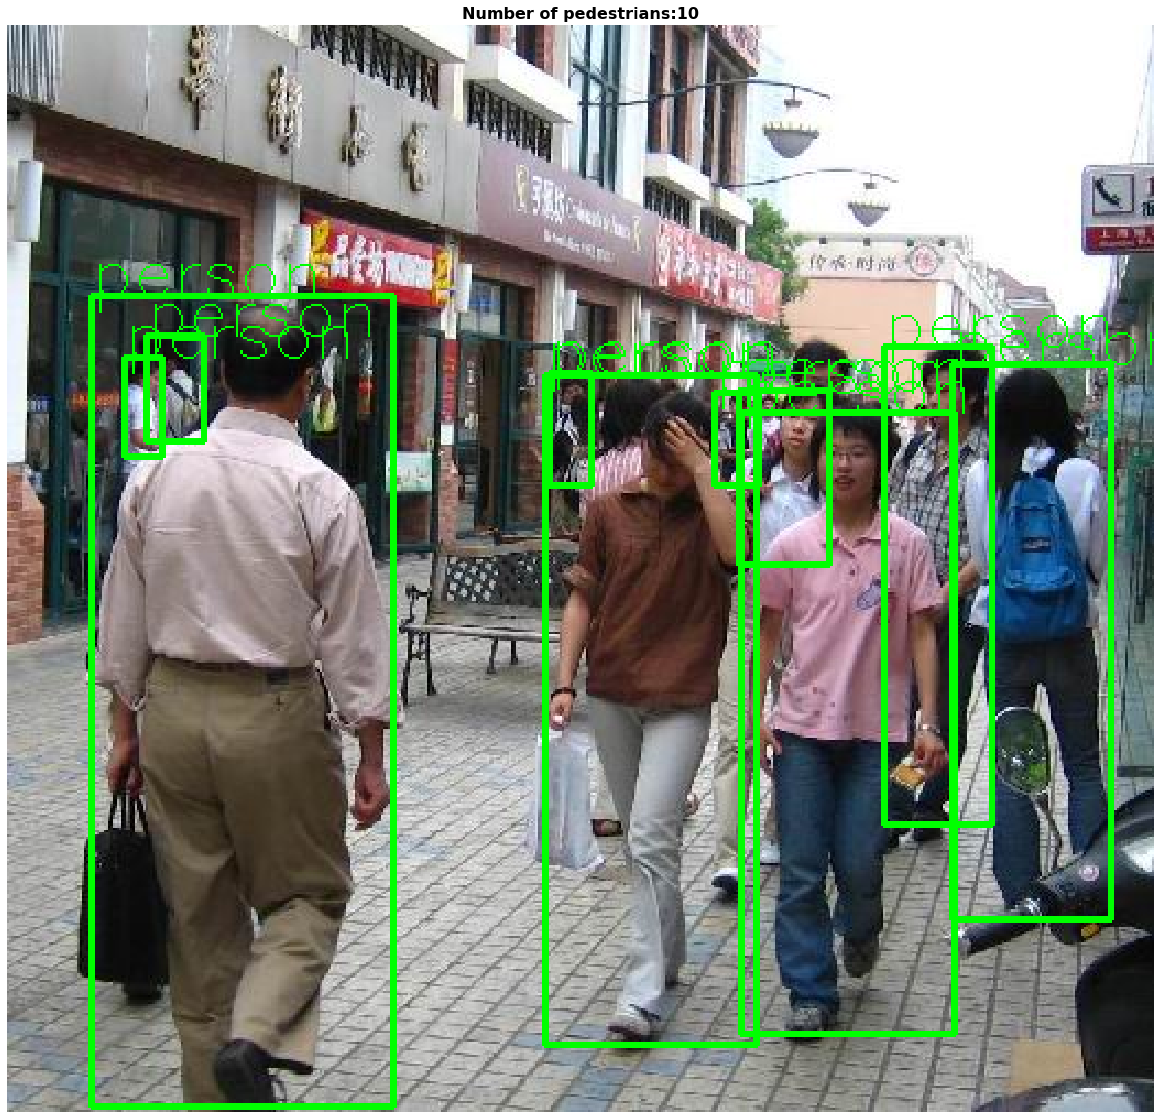

In [21]:
plt.figure(figsize=(25,20))
plt.axis('off')
plt.title('Number of pedestrians:{}'.format(num_ped), fontweight='bold', fontsize='16')
plt.imshow(boxed_img)
plt.show()